In [1]:
# Necessary libraries
import numpy as np
import math

import pandas as pd
pd.set_option('display.max_colwidth', None)

# Data cleaning
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Data visualization for exploratory data analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor

In [2]:
def rmsle(validation, prediction):
    return math.sqrt(mean_squared_log_error(validation, prediction))

In [3]:
train_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
test_path = '/kaggle/input/house-prices-advanced-regression-techniques/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Simple Model
What do we want in a house? I think some of the things to note is:
1. How large is the house?
2. How's the quality of the house?
3. How old is the house and when was the last renovation?

My hypothesis is the larger the house, the more it will cost. The greater the quality of the house is, the more it will cost too. And the newer the house is, the more it will cost.

## Impact of House's Price to it's Price

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

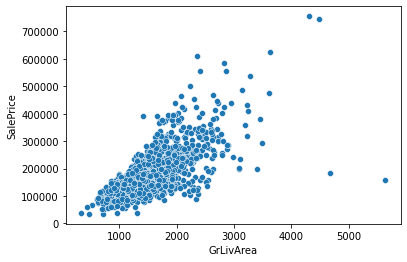

In [5]:
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

Seems quite linear, until it hits more than 4000 sqf, seems like we can just remove it so it doesn't affect our model's performance.

In [6]:
train.drop(train[train.GrLivArea > 4000].index, inplace=True)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

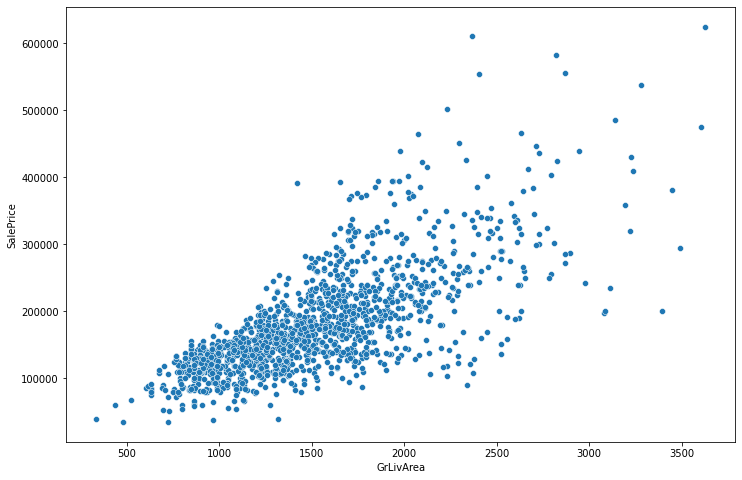

In [7]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')

## The Quality of The House

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

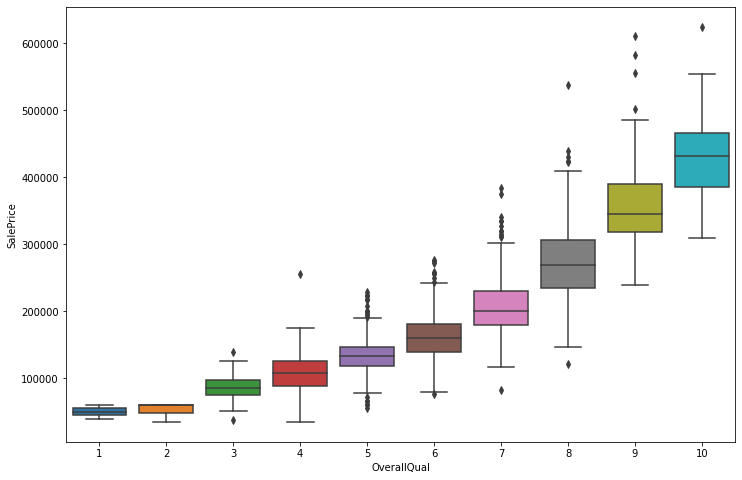

In [8]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=train, x='OverallQual', y='SalePrice')

## Impact of House's Age

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

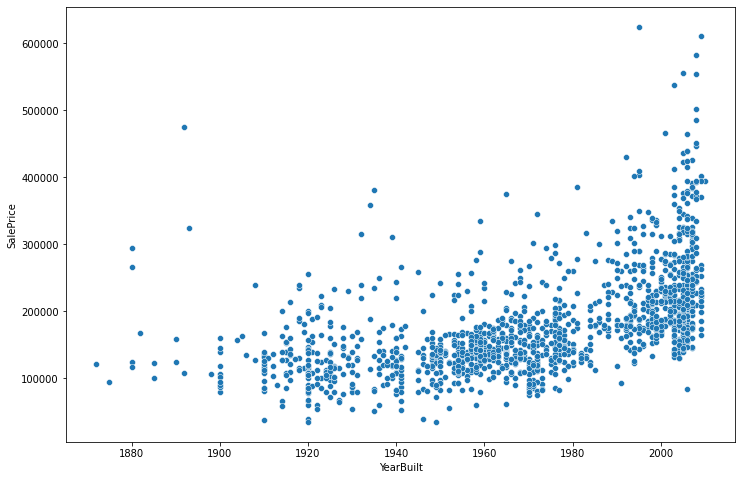

In [9]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x='YearBuilt', y='SalePrice')

## Building the Simple Model with XGB

In [10]:
features = ['GrLivArea', 'OverallQual', 'YearBuilt']
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train.SalePrice)

In [11]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [12]:
validation = xgb.predict(X_valid)
rmsle(y_valid, validation)

0.19173440993366941

## Predicting

In [13]:
prediction = xgb.predict(test[features])
submission = pd.DataFrame({
    'id': test.Id,
    'SalePrice': prediction
})
submission.to_csv('submission.csv', index=False)
print('Successfully made a prediction!')

Successfully made a prediction!


# Improving the simple model with simple transformations

In [33]:
train['GrLivArea_log'] = np.log1p(train['GrLivArea'])
train['BuildingAge'] = 2022 - train['YearBuilt']
train['OverallQual_log'] = np.log1p(train['OverallQual'])

test['GrLivArea_log'] = np.log1p(test['GrLivArea'])
test['BuildingAge'] = 2022 - test['YearBuilt']
test['OverallQual_log'] = np.log1p(test['OverallQual'])

In [29]:
features = ['GrLivArea_log', 'BuildingAge', 'OverallQual_log']
X_train, X_valid, y_train, y_valid = train_test_split(train[features], train.SalePrice)

In [30]:
xgb.fit(X_train, y_train)
prediction = xgb.predict(X_valid)
rmsle(y_valid, prediction)

0.18639734088321191

In [34]:
prediction = xgb.predict(test[features])
submission = pd.DataFrame({
    'id': test.Id,
    'SalePrice': prediction
})
submission.to_csv('submission.csv', index=False)
print('Successfully made a prediction!')

Successfully made a prediction!
